In [1]:
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, r2_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb
import shap

import warnings
warnings.filterwarnings('ignore')

def warn(*args, **kwargs): #suppress scikit-learn warnings
    pass

warnings.warn = warn

In [2]:
df = pd.read_csv('movie_metadata.csv')
df.head()

# movie dataset from dataworld 

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [3]:
df.shape

(5043, 28)

In [4]:
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

There are a total of 5043 entries and 28 columns. There are many entries with missing values including 'gross' which is the going to be the target. Another potential issue with this data is that there are several categories with Facebook related information, ie. movie_facebook_likes but there are many movies that were released before Facebook's time.

## Cleaning Dataset

In [6]:
# Facebook began in 2004, since we might be looking at Facebook likes, we start with movies from 2005
df.loc[df.title_year>2004.0, 'movie_title'].count()

2646

In [7]:
# find any null value in 'gross'
df.loc[df.title_year>2004.0, 'gross'].isna().sum()

490

In [8]:
# find any null value in 'budget'
df.loc[df.title_year>2004.0, 'budget'].isna().sum()

286

In [9]:
# drop movies before 2005
df1 = df.drop(df.loc[df.title_year<2005.0].index, axis=0)

In [10]:
# drop all rows with null in 'gross' or 'budget'
df1.drop(df1.loc[df1['gross'].isna()].index, axis=0, inplace=True)
df1.drop(df1.loc[df1['budget'].isna()].index, axis=0, inplace=True)

In [11]:
sum(df1.apply(lambda x: x.count(), axis=1)<25) #number of rows with more than 3 nan values

5

In [12]:
# find how many 0 values in the various facebook_likes features
print('Movie Facebook Likes: {}'.format(sum(df1.movie_facebook_likes==0)))
print('Director Facebook Likes: {}'.format(sum(df1.director_facebook_likes==0)))
print('Actor 1 Facebook Likes: {}'.format(sum(df1.actor_1_facebook_likes==0)))
print('Actor 2 Facebook Likes: {}'.format(sum(df1.actor_2_facebook_likes==0)))
print('Actor 3 Facebook Likes: {}'.format(sum(df1.actor_3_facebook_likes==0)))
print('Cast Total Facebook Likes: {}'.format(sum(df1.cast_total_facebook_likes==0)))

Movie Facebook Likes: 797
Director Facebook Likes: 321
Actor 1 Facebook Likes: 5
Actor 2 Facebook Likes: 11
Actor 3 Facebook Likes: 20
Cast Total Facebook Likes: 7


The number of movie and director Facebook likes with zero likes is abnormally high considering that all the older movies are no longer in the data. There is no explanation from the data source why such a large number of movies and director got no likes.

In [13]:
# drop features that we won't use
df2=df1.drop(['color', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'plot_keywords', 'movie_imdb_link', 'aspect_ratio', 'director_name'], axis=1)

In [14]:
df2.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,movie_title,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,4834,0.0,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,33000
1,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,471220,48350,0.0,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,0
2,602.0,148.0,0.0,161.0,11000.0,200074175.0,Action|Adventure|Thriller,Spectre,275868,11700,1.0,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,85000
3,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,Action|Thriller,The Dark Knight Rises,1144337,106759,0.0,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,164000
5,462.0,132.0,475.0,530.0,640.0,73058679.0,Action|Adventure|Sci-Fi,John Carter,212204,1873,1.0,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,24000


Many of the movies have multiple genres, ie. action|adventure|sci-fi. This feature has to be encoded properly as categorial data.

In [15]:
# function to create a separate column for each movie genre
df2['Action']=np.zeros([1966, 1])
df2['Adventure']=np.zeros([1966, 1])
df2['Animation']=np.zeros([1966, 1])
df2['Biography']=np.zeros([1966, 1])
df2['Comedy']=np.zeros([1966, 1])
df2['Crime']=np.zeros([1966, 1])
df2['Documentary']=np.zeros([1966, 1])
df2['Drama']=np.zeros([1966, 1])
df2['Fantasy']=np.zeros([1966, 1])
df2['Horror']=np.zeros([1966, 1])
df2['Mystery']=np.zeros([1966, 1])
df2['Romance']=np.zeros([1966, 1])
df2['Sci-Fi']=np.zeros([1966, 1])
df2['Thriller']=np.zeros([1966, 1])
df2['Western']=np.zeros([1966, 1])

for index, entry in enumerate(df2.genres):
    string=[]
    string=entry.split('|')
    for i in string:
        if i=='Action':
            df2.Action[index]=1
        elif i=='Adventure':
            df2.Adventure[index]=1
        elif i=='Animation':
            df2.Animation[index]=1
        elif i=='Biography':
            df2.Biography[index]=1
        elif i=='Comedy':
            df2.Comedy[index]=1
        elif i=='Crime':
            df2.Crime[index]=1
        elif i=='Documentary':
            df2.Documentary[index]=1
        elif i=='Drama':
            df2.Drama[index]=1
        elif i=='Fantasy':
            df2.Fantasy[index]=1
        elif i=='Horror':
            df2.Horror[index]=1
        elif i=='Mystery':
            df2.Mystery[index]=1
        elif i=='Romance':
            df2.Romance[index]=1
        elif i=='Sci-Fi':
            df2['Sci-Fi'][index]=1    
        elif i=='Thriller':
            df2.Thriller[index]=1
        elif i=='Western':
            df2.Western[index]=1

df2.drop('genres', axis=1, inplace=True)

In [16]:
# eliminate duplicates in "movie_title"
df2.drop_duplicates('movie_title', inplace=True)

In [17]:
df2.isnull().sum()

num_critic_for_reviews        1
duration                      1
director_facebook_likes       0
actor_3_facebook_likes        5
actor_1_facebook_likes        2
gross                         0
movie_title                   0
num_voted_users               0
cast_total_facebook_likes     0
facenumber_in_poster          6
num_user_for_reviews          0
language                      2
country                       0
content_rating               29
budget                        0
title_year                    0
actor_2_facebook_likes        4
imdb_score                    0
movie_facebook_likes          0
Action                        0
Adventure                     0
Animation                     0
Biography                     0
Comedy                        0
Crime                         0
Documentary                   0
Drama                         0
Fantasy                       0
Horror                        0
Mystery                       0
Romance                       0
Sci-Fi  

Except for content_rating, only a few categories have 6 or less missing values.

In [18]:
df2['language'].fillna("English", inplace=True) # fill with the most popular language
df2['content_rating'].fillna("Not Rated", inplace=True) 

In [19]:
# examine content_rating column
df2.content_rating.value_counts()

R            786
PG-13        734
PG           273
Not Rated     61
G             33
Unrated       10
NC-17          2
Name: content_rating, dtype: int64

In [20]:
df2.content_rating.replace('Unrated', 'Not Rated', inplace=True) # merge similar categories into one

In [21]:
df2.country.value_counts()

USA               1477
UK                 155
France              60
Germany             39
Canada              33
Australia           16
Spain               15
China               11
India               10
Mexico               7
Hong Kong            7
South Korea          6
Denmark              6
Japan                5
Ireland              5
New Zealand          5
Italy                3
Brazil               3
Israel               3
Thailand             3
South Africa         3
Norway               3
Iceland              2
Czech Republic       2
Russia               2
Belgium              2
Hungary              2
Netherlands          2
Greece               1
Poland               1
Indonesia            1
Official site        1
Chile                1
Romania              1
Georgia              1
Taiwan               1
Argentina            1
Finland              1
Iran                 1
Philippines          1
Name: country, dtype: int64

In [22]:
# label encode content_rating, language and country
content_series=pd.Series(df2.content_rating)
cat_content=content_series.astype('category')
df2['content_rating_encoded']=cat_content.cat.codes

language_series=pd.Series(df2.language)
cat_language=language_series.astype('category')
df2['language_encoded']=cat_language.cat.codes

country_series=pd.Series(df2.country)
cat_country=country_series.astype('category')
df2['country_encoded']=cat_country.cat.codes

In [23]:
# eliminate content_rating, language and country
df2.drop(['content_rating', 'language', 'country'], axis=1, inplace=True)

In [24]:
df2.fillna(df2.mean(), inplace=True)

In [25]:
df2.isnull().sum()

num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_1_facebook_likes       0
gross                        0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
facenumber_in_poster         0
num_user_for_reviews         0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
Action                       0
Adventure                    0
Animation                    0
Biography                    0
Comedy                       0
Crime                        0
Documentary                  0
Drama                        0
Fantasy                      0
Horror                       0
Mystery                      0
Romance                      0
Sci-Fi                       0
Thriller                     0
Western                      0
content_rating_encoded       0
language

In [26]:
df2.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller,Western,content_rating_encoded,language_encoded,country_encoded
count,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1.899000e+03,1.899000e+03,1899.000000,1899.000000,1899.000000,...,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000
mean,216.653846,108.543203,693.081622,931.385956,8593.687928,5.334825e+07,1.081380e+05,13010.191153,1.533016,311.743549,...,0.007372,0.003160,0.004739,0.003160,0.000527,0.001053,0.000527,4.122696,8.487098,35.379147
std,138.953244,19.225753,2860.078113,2336.297532,13549.243342,7.519024e+07,1.435578e+05,18830.232791,2.388194,383.957140,...,0.085568,0.056136,0.068698,0.056136,0.022948,0.032444,0.022948,0.990048,2.885452,9.479361
min,1.000000,41.000000,0.000000,0.000000,0.000000,1.620000e+02,2.200000e+01,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118.000000,95.000000,12.000000,187.500000,771.500000,5.725608e+06,2.139500e+04,1949.500000,0.000000,100.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,8.000000,39.000000
50%,191.000000,105.000000,64.000000,437.000000,2000.000000,2.782987e+07,5.929700e+04,4774.000000,1.000000,195.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,8.000000,39.000000
75%,288.000000,118.000000,212.000000,729.500000,14000.000000,6.700586e+07,1.368170e+05,18662.500000,2.000000,376.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,8.000000,39.000000
max,813.000000,240.000000,23000.000000,23000.000000,260000.000000,7.605058e+08,1.676169e+06,303717.000000,43.000000,4667.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,33.000000,39.000000


## Visualizing Data

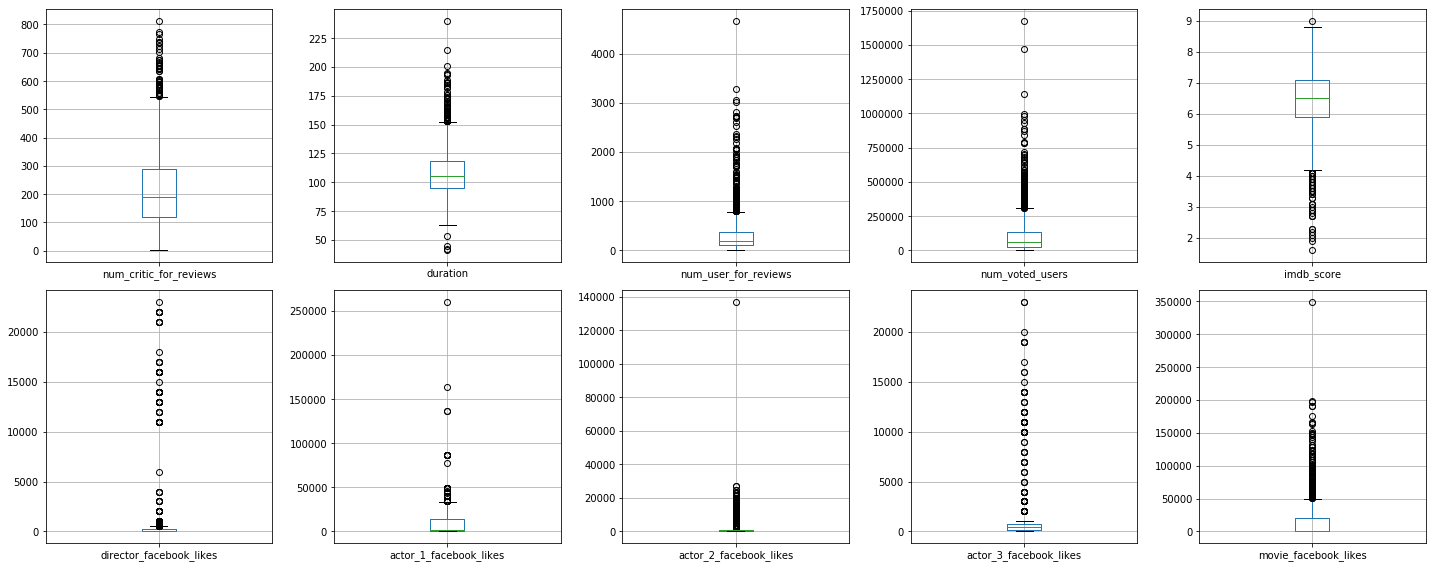

In [27]:
plotdata = df2[['num_critic_for_reviews', 'duration', 'num_user_for_reviews', 'num_voted_users', 'imdb_score', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'movie_facebook_likes']]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8)) # create figure and axes

for i, el in enumerate(list(plotdata.columns.values)[:]):
    a = plotdata.boxplot(el, ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

All of the boxplots except for imdb_score are skewed to higher values. This hints that some kind of data tranformation is warrant in these cases.

In [28]:
# log transform features with extreme skewness
(df2[['log_num_user_for_reviews', 'log_num_voted_users', 'log_director_facebook_likes', 
      'log_actor_1_facebook_likes', 'log_actor_2_facebook_likes', 'log_actor_3_facebook_likes', 
      'log_movie_facebook_likes', 'log_cast_total_facebook_likes']]) = (df2[['num_user_for_reviews', 
      'num_voted_users', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 
      'actor_3_facebook_likes', 'movie_facebook_likes', 'cast_total_facebook_likes']].
      transform(lambda x: np.log(x+1)))

# square root transform features with less severe skewness
df2[['sqrt_num_critic_for_reviews', 'sqrt_duration']] = df2[['num_critic_for_reviews', 'duration']].transform(lambda x: np.sqrt(x))

df2.drop(['num_critic_for_reviews', 'duration', 'num_user_for_reviews', 'num_voted_users', 
          'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 
          'actor_3_facebook_likes', 'movie_facebook_likes', 'cast_total_facebook_likes'], axis=1, inplace=True)

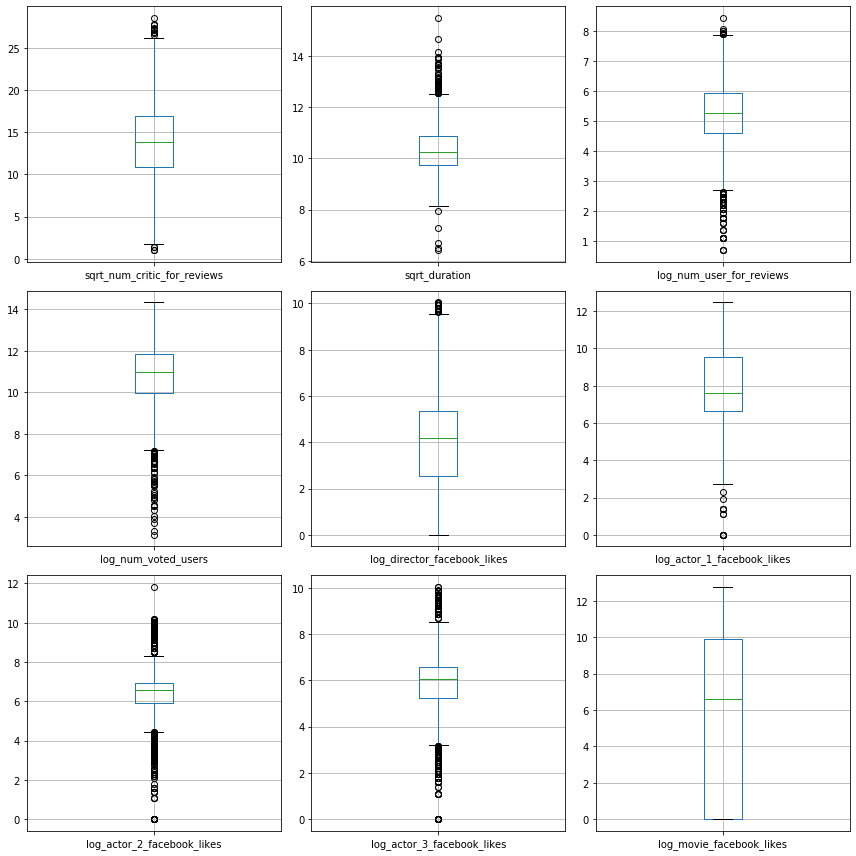

In [29]:
plotdata = (df2[['sqrt_num_critic_for_reviews', 'sqrt_duration', 'log_num_user_for_reviews', 
                 'log_num_voted_users', 'log_director_facebook_likes', 'log_actor_1_facebook_likes', 
                 'log_actor_2_facebook_likes', 'log_actor_3_facebook_likes', 'log_movie_facebook_likes']])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12)) # create figure and axes

for i, el in enumerate(list(plotdata.columns.values)[:]):
    a = plotdata.boxplot(el, ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

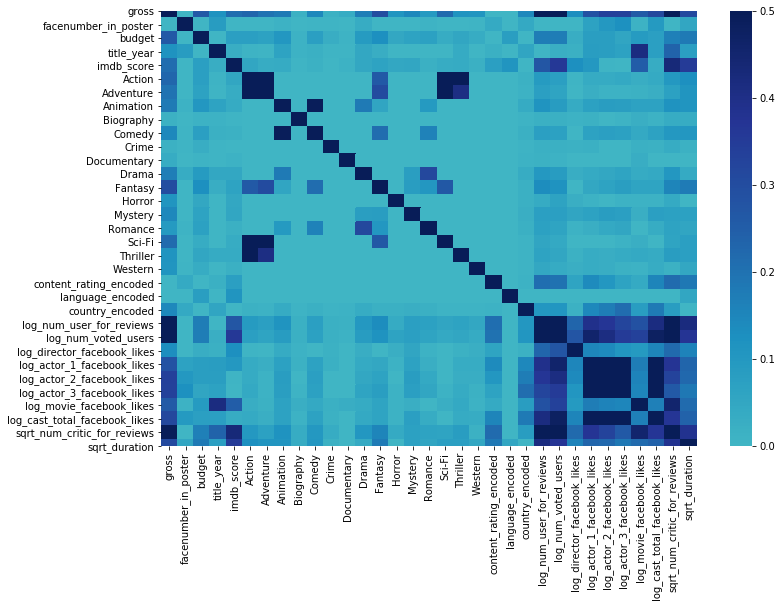

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df2.corr(), center=0, ax=ax, cmap="YlGnBu", vmin=0, vmax=0.5)

It appears that there is some correlation among the newly transformed data, albeit minor.

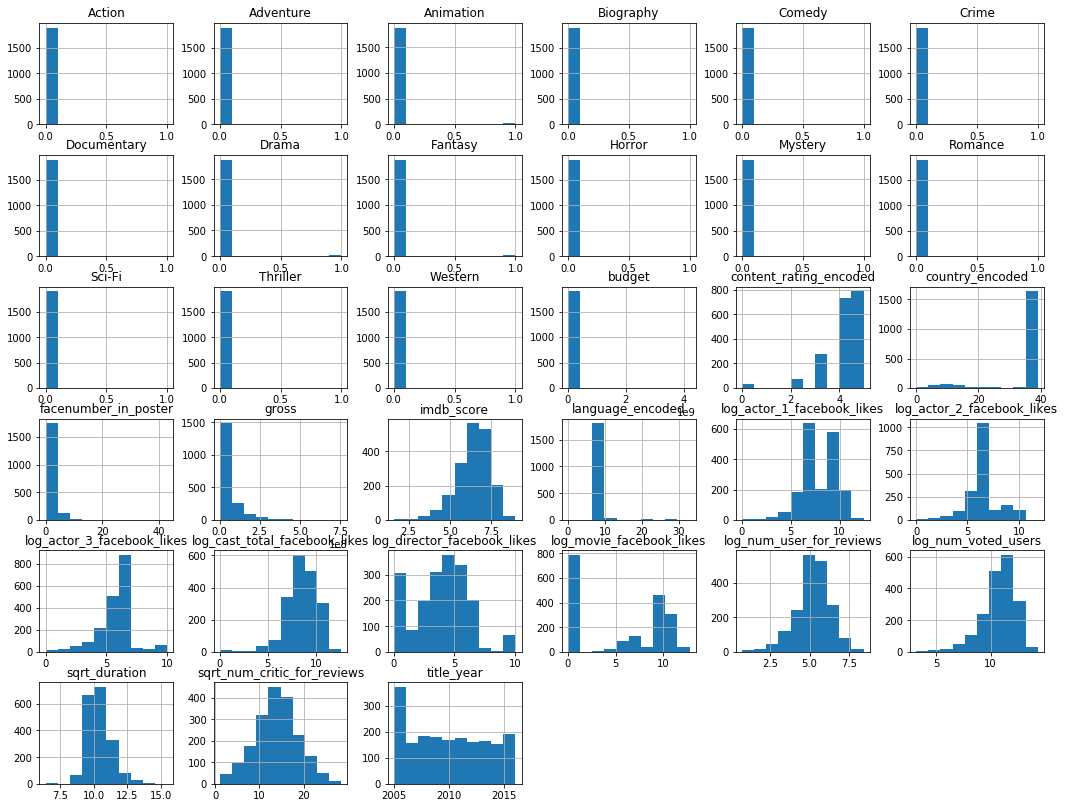

In [31]:
fig = plt.figure(figsize = (18,14))
ax = fig.gca()
df2.hist(ax = ax);

The data transformation made the features more normally distributed

# Baseline Model

### Logistic Regression

In [32]:
# Classifying whether a movie is a "success", determined by whether its revenue generated or "gross" is
# at least 2X amount spent, or "budget"

y=(df2.gross>=2*df2.budget) # create our target
# create our X
X=df2.drop(['gross', 'movie_title'], axis=1)
print(f'{y.sum()} out of {len(y)} movies are successful.')

447 out of 1899 movies are successful.


In [33]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=88, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.2, random_state=88, shuffle=False)

In [34]:
logreg_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', 
                  LogisticRegression(fit_intercept = False, C = 1e12, random_state=100))])

model_logreg = logreg_pipeline.fit(X_train, y_train)

y_hat_train = logreg_pipeline.predict(X_train)
y_hat_val = logreg_pipeline.predict(X_val)

In [35]:
def display_matrix(actual_y, prediction_y, data='Training Set', method='Classifier'):
    cf = confusion_matrix(actual_y, prediction_y)
    
    if data == 'Training Set':
        plt.imshow(cf, cmap=plt.cm.Purples, aspect='auto')
    else:
        plt.imshow(cf, cmap=plt.cm.Greens, aspect='auto')
    
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    class_names = set(y)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cf.max() / 2.

    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
            plt.text(j, i, cf[i, j],
                     verticalalignment="bottom",
                     horizontalalignment="center",
                     color="black")
    
    plt.colorbar()

    print(f'Classification Report for {data}:\n')
    print(classification_report(actual_y, prediction_y))
    print("{} Accuracy for {}: {:.4}%".format(data, method, accuracy_score(actual_y, prediction_y) * 100))

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.85      0.88      0.87       922
        True       0.58      0.52      0.55       293

   micro avg       0.80      0.80      0.80      1215
   macro avg       0.72      0.70      0.71      1215
weighted avg       0.79      0.80      0.79      1215

Training Set Accuracy for Logistic Regression: 79.51%


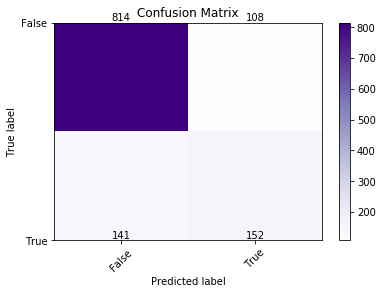

In [36]:
display_matrix(y_train, y_hat_train, data='Training Set', method='Logistic Regression')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.89      0.92      0.91       239
        True       0.67      0.57      0.62        65

   micro avg       0.85      0.85      0.85       304
   macro avg       0.78      0.75      0.76       304
weighted avg       0.84      0.85      0.84       304

Validation Set Accuracy for Logistic Regression: 84.87%


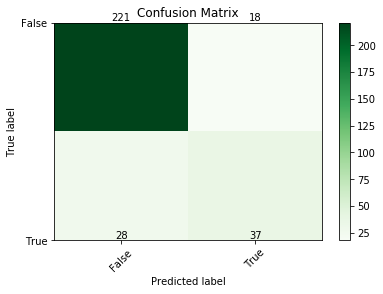

In [37]:
display_matrix(y_val, y_hat_val, data='Validation Set', method='Logistic Regression')

In [38]:
def roc_graph(actual_y, prediction_y):
    fpr, tpr, threshold = roc_curve(actual_y, prediction_y)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

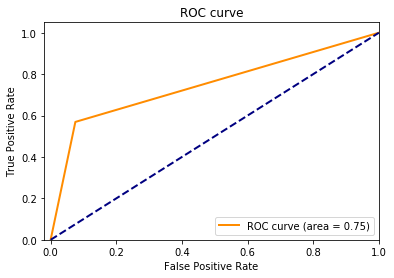

In [39]:
roc_graph(y_val, y_hat_val)

### Logistic Regression with L1 Regularization

In [40]:
reglogreg_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(fit_intercept = False, C = 1e12, penalty='l1', class_weight={1:2, 0:1}, random_state=100))])
model_reglogreg = reglogreg_pipeline.fit(X_train, y_train)
y_hat_train1 = reglogreg_pipeline.predict(X_train)
y_hat_val1 = reglogreg_pipeline.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.90      0.76      0.82       922
        True       0.49      0.72      0.58       293

   micro avg       0.75      0.75      0.75      1215
   macro avg       0.69      0.74      0.70      1215
weighted avg       0.80      0.75      0.77      1215

Training Set Accuracy for regularized Logistic Regression: 75.14%


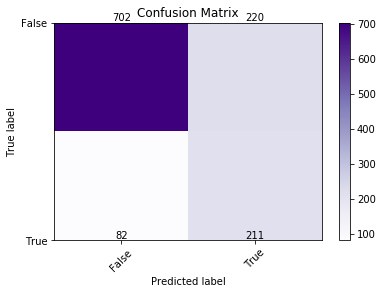

In [41]:
display_matrix(y_train, y_hat_train1, data='Training Set', method='regularized Logistic Regression')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.91      0.77      0.83       239
        True       0.46      0.71      0.55        65

   micro avg       0.76      0.76      0.76       304
   macro avg       0.68      0.74      0.69       304
weighted avg       0.81      0.76      0.77       304

Validation Set Accuracy for regularized Logistic Regression: 75.66%


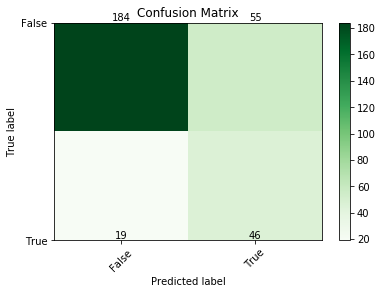

In [42]:
display_matrix(y_val, y_hat_val1, data='Validation Set', method='regularized Logistic Regression')

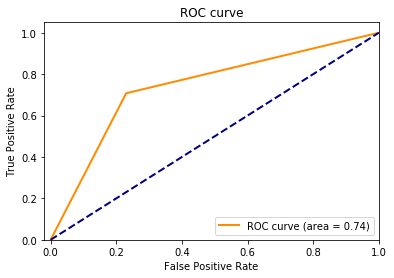

In [43]:
roc_graph(y_val, y_hat_val1)

### Logistic Regression with Weights

In [44]:
wlogreg_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(fit_intercept = False, C = 1e12, class_weight={1:2, 0:1}, random_state=100))])
model_wlogreg = wlogreg_pipeline.fit(X_train, y_train)
y_hat_train2 = wlogreg_pipeline.predict(X_train)
y_hat_val2 = wlogreg_pipeline.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.88      0.84      0.86       922
        True       0.56      0.64      0.59       293

   micro avg       0.79      0.79      0.79      1215
   macro avg       0.72      0.74      0.73      1215
weighted avg       0.80      0.79      0.79      1215

Training Set Accuracy for Logistic Regression with weights: 79.01%


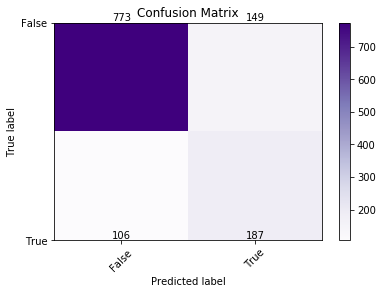

In [45]:
display_matrix(y_train, y_hat_train2, data='Training Set', method='Logistic Regression with weights')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.90      0.85      0.88       239
        True       0.54      0.66      0.60        65

   micro avg       0.81      0.81      0.81       304
   macro avg       0.72      0.76      0.74       304
weighted avg       0.83      0.81      0.82       304

Validation Set Accuracy for Logistic Regression with weights: 80.92%


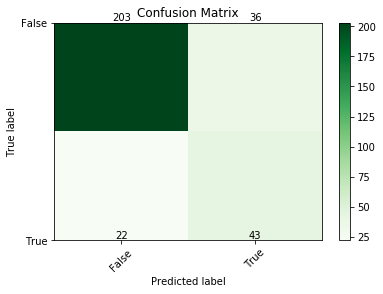

In [46]:
display_matrix(y_val, y_hat_val2, data='Validation Set', method='Logistic Regression with weights')

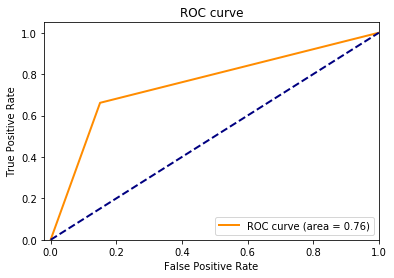

In [47]:
roc_graph(y_val, y_hat_val2)

## Additional Models

### Decision Tree

In [48]:
tree_clf = DecisionTreeClassifier(criterion='entropy', random_state=100)
model_tree_clf = tree_clf.fit(X_train, y_train)
train_pred = tree_clf.predict(X_train)
val_pred = tree_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       922
        True       1.00      1.00      1.00       293

   micro avg       1.00      1.00      1.00      1215
   macro avg       1.00      1.00      1.00      1215
weighted avg       1.00      1.00      1.00      1215

Training Set Accuracy for Decision Tree: 100.0%


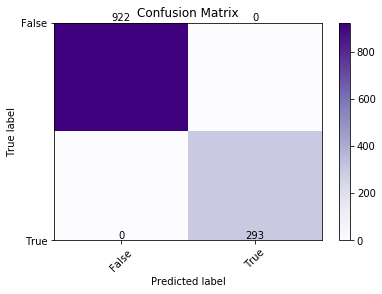

In [49]:
display_matrix(y_train, train_pred, data='Training Set', method='Decision Tree')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.87      0.80      0.83       239
        True       0.43      0.55      0.49        65

   micro avg       0.75      0.75      0.75       304
   macro avg       0.65      0.68      0.66       304
weighted avg       0.78      0.75      0.76       304

Validation Set Accuracy for Decision Tree: 75.0%


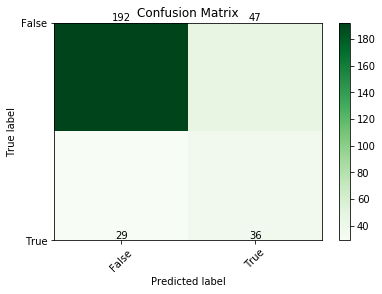

In [50]:
display_matrix(y_val, val_pred, data='Validation Set', method='Decision Tree')

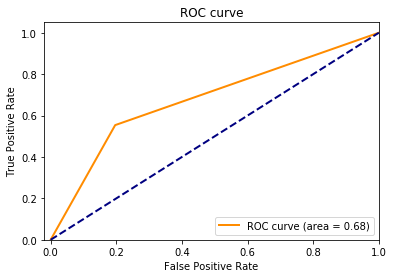

In [51]:
roc_graph(y_val, val_pred)

### Pruning Tree

In [142]:
def opt_param_plot(classifier, param_name, param_range):
    
    train_results, test_results = get_results(classifier, param_name, param_range)
    
    plt.figure(figsize=(10,6))
    plt.plot(param_range, train_results, 'b', label='Train AUC')
    plt.plot(param_range, test_results, 'r', label='Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel(param_name)
    plt.legend()
    plt.show()

def get_results(classifier, param_name, param_range):
    train_results = []
    test_results = []
    params = [{param_name: p} for p in param_range]
    
    for param in params:
        model = classifier(criterion='entropy', **param)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous train results
        train_results.append(roc_auc)
        y_pred = model.predict(X_val)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous test results
        test_results.append(roc_auc)
    
    return train_results, test_results
    

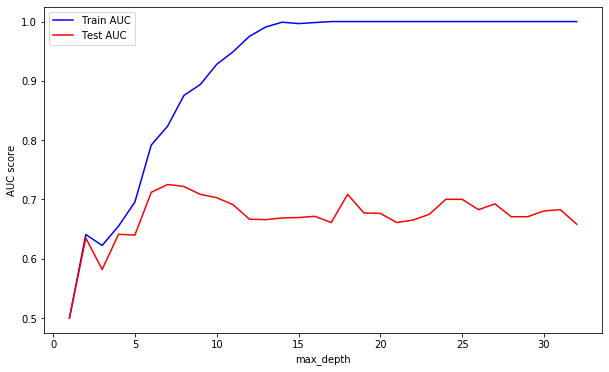

In [143]:
opt_param_plot(DecisionTreeClassifier, param_name='max_depth', param_range=np.linspace(1, 32, 32, endpoint=True))

optimal tree depth as 6

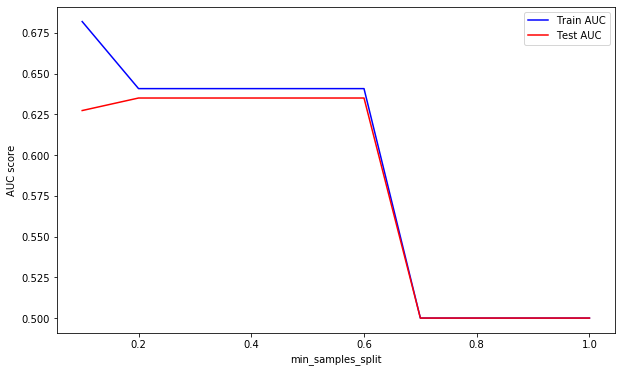

In [144]:
opt_param_plot(DecisionTreeClassifier, param_name='min_samples_split', param_range=np.linspace(0.1, 1.0, 10, endpoint=True))

optimal minimum sample split is 0.2 - 0.6

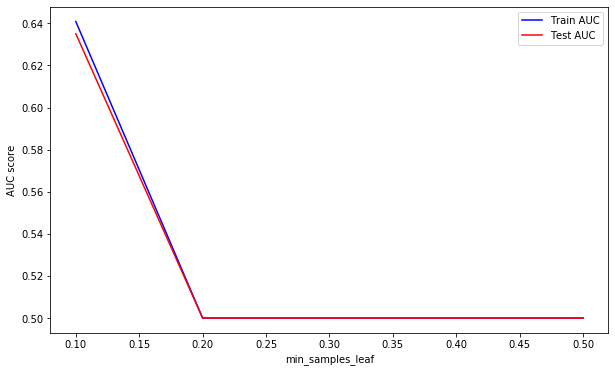

In [145]:
opt_param_plot(DecisionTreeClassifier, param_name='min_samples_leaf', param_range=np.linspace(0.1, 0.5, 5, endpoint=True))

optimal minimum sample leafs is 0.10

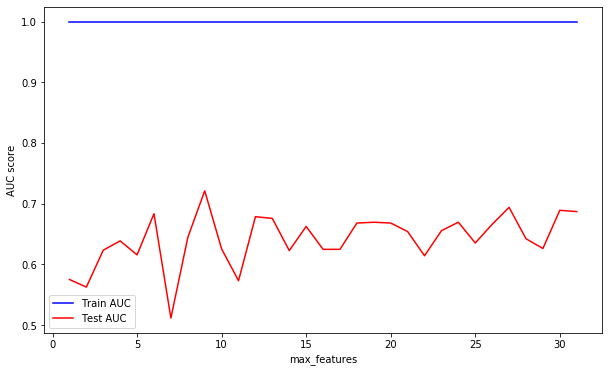

In [146]:
opt_param_plot(DecisionTreeClassifier, param_name='max_features', param_range=list(range(1,X_train.shape[1])))

optimal number of features is 23

In [57]:
# Train the classifier with optimal values identified
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=23,
                           max_depth=7,
                           min_samples_split=0.4,
                           min_samples_leaf=0.1,
                           random_state=100)
model_dt = dt.fit(X_train, y_train)
train_pred1 = dt.predict(X_train)
val_pred1 = dt.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.82      0.89      0.86       922
        True       0.54      0.39      0.45       293

   micro avg       0.77      0.77      0.77      1215
   macro avg       0.68      0.64      0.65      1215
weighted avg       0.75      0.77      0.76      1215

Training Set Accuracy for pruned Decision Tree: 77.12%


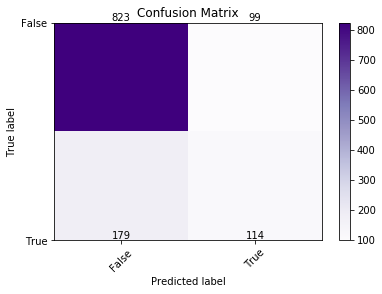

In [58]:
display_matrix(y_train, train_pred1, data='Training Set', method='pruned Decision Tree')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.84      0.92      0.88       239
        True       0.53      0.35      0.43        65

   micro avg       0.80      0.80      0.80       304
   macro avg       0.69      0.64      0.65       304
weighted avg       0.77      0.80      0.78       304

Validation Set Accuracy for pruned Decision Tree: 79.61%


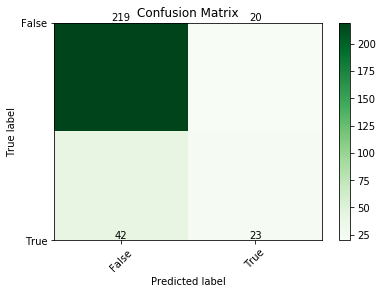

In [59]:
display_matrix(y_val, val_pred1, data='Validation Set', method='pruned Decision Tree')

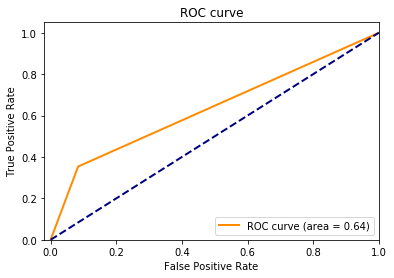

In [60]:
roc_graph(y_val, val_pred1)

### Bagging Trees

In [61]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', 
                                max_depth=9), n_estimators=30, random_state=100)
model_bagged_tree = bagged_tree.fit(X_train, y_train)
train_pred2 = bagged_tree.predict(X_train)
val_pred2 = bagged_tree.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.95      1.00      0.97       922
        True       1.00      0.84      0.91       293

   micro avg       0.96      0.96      0.96      1215
   macro avg       0.98      0.92      0.94      1215
weighted avg       0.96      0.96      0.96      1215

Training Set Accuracy for Bagged Tree: 96.05%


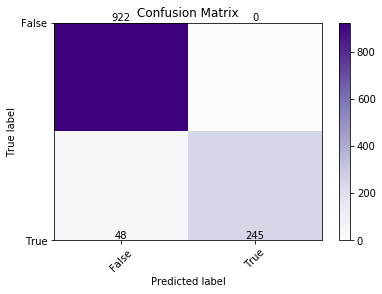

In [62]:
display_matrix(y_train, train_pred2, data='Training Set', method='Bagged Tree')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.85      0.95      0.90       239
        True       0.66      0.38      0.49        65

   micro avg       0.83      0.83      0.83       304
   macro avg       0.75      0.67      0.69       304
weighted avg       0.81      0.83      0.81       304

Validation Set Accuracy for Bagged Tree: 82.57%


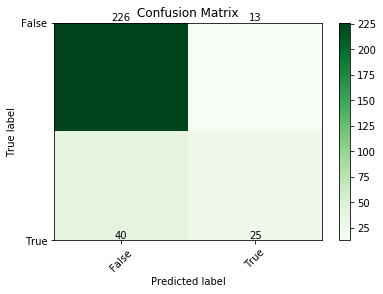

In [63]:
display_matrix(y_val, val_pred2, data='Validation Set', method='Bagged Tree')

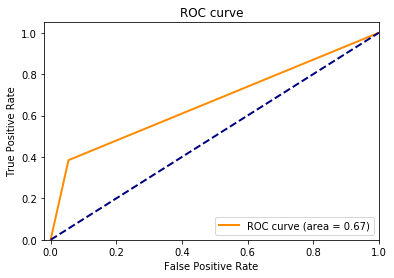

In [64]:
roc_graph(y_val, val_pred2)

### Random Forest

In [65]:
rf_clf = RandomForestClassifier(max_features=23, max_depth=8, n_estimators=1000, random_state=100)
model_rf_clf = rf_clf.fit(X_train, y_train)
train_pred3 = rf_clf.predict(X_train)
val_pred3 = rf_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.93      1.00      0.97       922
        True       1.00      0.78      0.88       293

   micro avg       0.95      0.95      0.95      1215
   macro avg       0.97      0.89      0.92      1215
weighted avg       0.95      0.95      0.94      1215

Training Set Accuracy for Random Forest: 94.65%


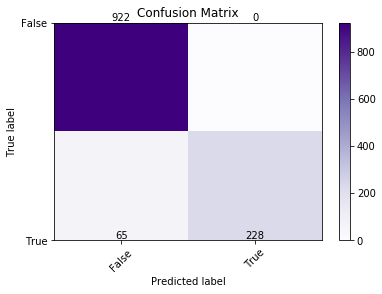

In [66]:
display_matrix(y_train, train_pred3, data='Training Set', method='Random Forest')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.84      0.97      0.90       239
        True       0.73      0.34      0.46        65

   micro avg       0.83      0.83      0.83       304
   macro avg       0.79      0.65      0.68       304
weighted avg       0.82      0.83      0.81       304

Validation Set Accuracy for Random Forest: 83.22%


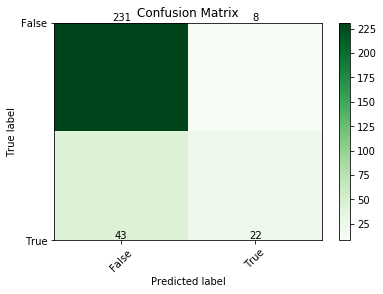

In [67]:
display_matrix(y_val, val_pred3, data='Validation Set', method='Random Forest')

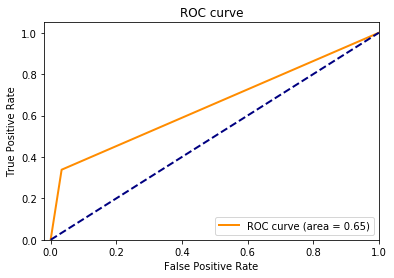

In [68]:
roc_graph(y_val, val_pred3)

### Random Forest with GridSearchCV

In [69]:
rf_clf = RandomForestClassifier(random_state=100)
rf_param_grid = {
                 'n_estimators': [100, 250, 500],
                 'criterion':['entropy'],
                 'max_depth':[6, 9],
                 'max_features': [16, 23],
                 'min_samples_split':[2, 4],
                 'min_samples_leaf':[5]
}

rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
train_pred4 = rf_grid_search.predict(X_train)
val_pred4 = rf_grid_search.predict(X_val)

print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
print("Optimal Parameters: {}".format(rf_grid_search.best_params_))

Testing Accuracy: 79.59%
Optimal Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 16, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 250}


Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.90      0.99      0.94       922
        True       0.97      0.66      0.78       293

   micro avg       0.91      0.91      0.91      1215
   macro avg       0.94      0.82      0.86      1215
weighted avg       0.92      0.91      0.91      1215

Training Set Accuracy for Random Forest: 91.19%


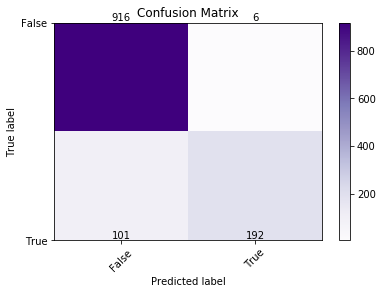

In [70]:
display_matrix(y_train, train_pred4, data='Training Set', method='Random Forest')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.84      0.97      0.90       239
        True       0.72      0.32      0.45        65

   micro avg       0.83      0.83      0.83       304
   macro avg       0.78      0.64      0.67       304
weighted avg       0.82      0.83      0.80       304

Validation Set Accuracy for Random Forest: 82.89%


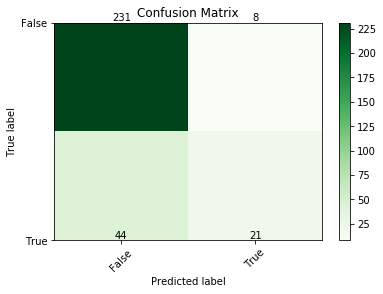

In [71]:
display_matrix(y_val, val_pred4, data='Validation Set', method='Random Forest')

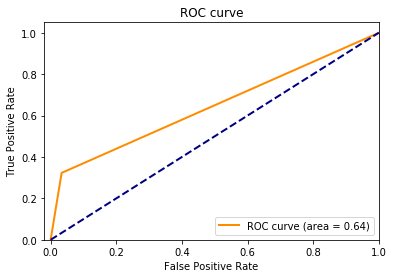

In [72]:
roc_graph(y_val, val_pred4)

### Random Forest with Weight

In [73]:
wrf_clf = RandomForestClassifier(max_features=23, max_depth=5, n_estimators=500, class_weight={1:2, 0:1}, random_state=100)
wrf_clf.fit(X_train, y_train)
wrf_pred_train = wrf_clf.predict(X_train)
wrf_pred_val = wrf_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.90      0.95      0.93       922
        True       0.81      0.68      0.74       293

   micro avg       0.88      0.88      0.88      1215
   macro avg       0.86      0.81      0.83      1215
weighted avg       0.88      0.88      0.88      1215

Training Set Accuracy for Random Forest with weights: 88.48%


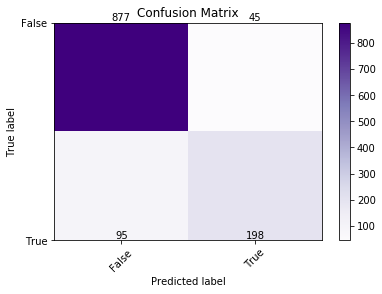

In [74]:
display_matrix(y_train, wrf_pred_train, data='Training Set', method='Random Forest with weights')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.86      0.92      0.89       239
        True       0.60      0.45      0.51        65

   micro avg       0.82      0.82      0.82       304
   macro avg       0.73      0.68      0.70       304
weighted avg       0.80      0.82      0.81       304

Validation Set Accuracy for Random Forest with weights: 81.91%


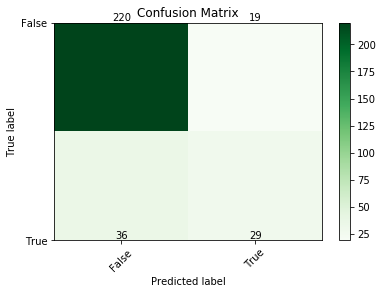

In [75]:
display_matrix(y_val, wrf_pred_val, data='Validation Set', method='Random Forest with weights')

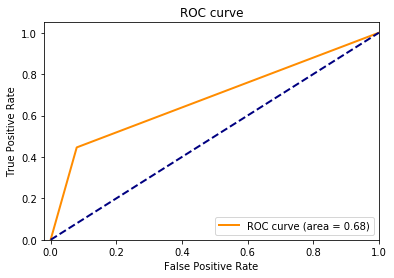

In [76]:
roc_graph(y_val, wrf_pred_val)

### Adaboost

In [77]:
ada_clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.4, random_state=100)
ada_model = ada_clf.fit(X_train, y_train)
ada_pred_train = ada_clf.predict(X_train)
ada_pred_val = ada_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.90      0.94      0.92       922
        True       0.79      0.67      0.72       293

   micro avg       0.88      0.88      0.88      1215
   macro avg       0.85      0.81      0.82      1215
weighted avg       0.87      0.88      0.87      1215

Training Set Accuracy for Adaboost: 87.74%


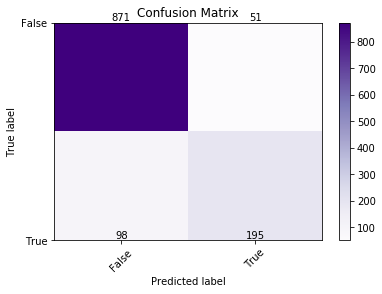

In [78]:
display_matrix(y_train, ada_pred_train, data='Training Set', method='Adaboost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.87      0.92      0.89       239
        True       0.62      0.48      0.54        65

   micro avg       0.83      0.83      0.83       304
   macro avg       0.74      0.70      0.72       304
weighted avg       0.81      0.83      0.82       304

Validation Set Accuracy for Adaboost: 82.57%


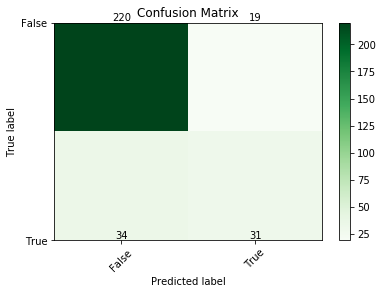

In [79]:
display_matrix(y_val, ada_pred_val, data='Validation Set', method='Adaboost')

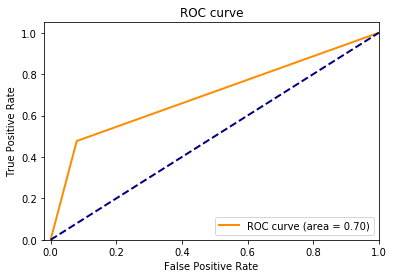

In [80]:
roc_graph(y_val, ada_pred_val)

### XGBoost

In [81]:
xgb_clf = xgb.XGBClassifier(eta=0.2, max_depth=5, subsample=0.5, scale_pos_weight=2.5, min_child_weight=15, num_parallel_tree=100, random_state=100)
xgb_clf.fit(X_train, y_train)

training_preds = xgb_clf.predict(X_train)
val_preds = xgb_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.95      0.91      0.93       922
        True       0.74      0.85      0.79       293

   micro avg       0.89      0.89      0.89      1215
   macro avg       0.85      0.88      0.86      1215
weighted avg       0.90      0.89      0.90      1215

Training Set Accuracy for XGBoost: 89.3%


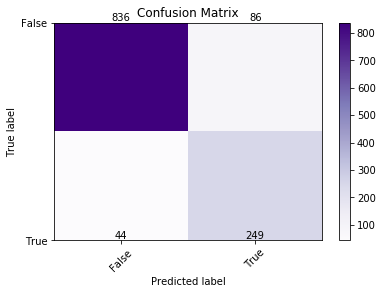

In [82]:
display_matrix(y_train, training_preds, data='Training Set', method='XGBoost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.91      0.88      0.90       239
        True       0.61      0.69      0.65        65

   micro avg       0.84      0.84      0.84       304
   macro avg       0.76      0.79      0.77       304
weighted avg       0.85      0.84      0.84       304

Validation Set Accuracy for XGBoost: 83.88%


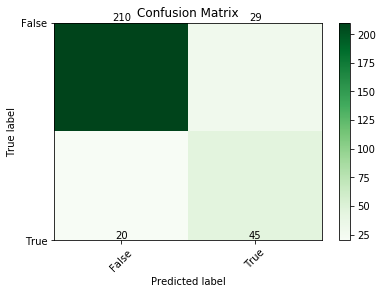

In [83]:
display_matrix(y_val, val_preds, data='Validation Set', method='XGBoost')

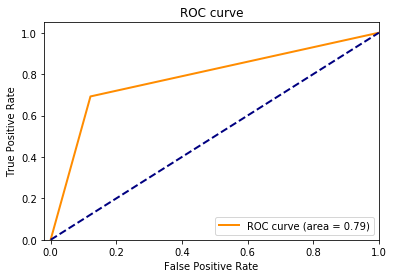

In [84]:
roc_graph(y_val, val_preds)

### XGBoost with GridSearchCV

In [85]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [7, 8],
    'min_child_weight': [12, 18],
    'subsample': [0.4, 0.5],
    'n_estimators': [100, 200]
    }

In [86]:
xgb_clf = xgb.XGBClassifier(scale_pos_weight=2.5, random_state=100)
grid_xgb_clf = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=5, n_jobs=4)
grid_xgb_clf.fit(X_train, y_train)

best_parameters = grid_xgb_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds1 = grid_xgb_clf.predict(X_train)
val_preds1 = grid_xgb_clf.predict(X_val)

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 7
min_child_weight: 12
n_estimators: 100
subsample: 0.5


Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.96      0.92      0.94       922
        True       0.77      0.87      0.82       293

   micro avg       0.91      0.91      0.91      1215
   macro avg       0.86      0.89      0.88      1215
weighted avg       0.91      0.91      0.91      1215

Training Set Accuracy for XGBoost: 90.53%


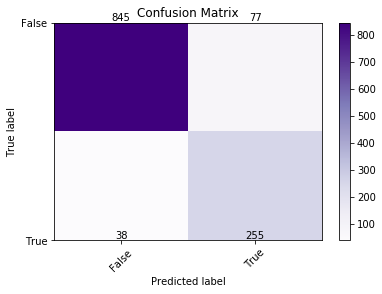

In [87]:
display_matrix(y_train, training_preds1, data='Training Set', method='XGBoost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.91      0.88      0.89       239
        True       0.60      0.66      0.63        65

   micro avg       0.83      0.83      0.83       304
   macro avg       0.75      0.77      0.76       304
weighted avg       0.84      0.83      0.84       304

Validation Set Accuracy for XGBoost: 83.22%


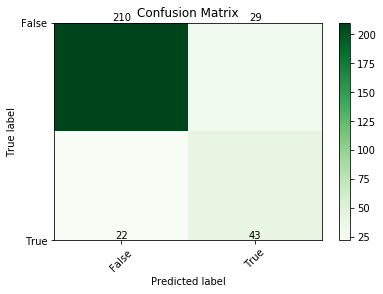

In [88]:
display_matrix(y_val, val_preds1, data='Validation Set', method='XGBoost')

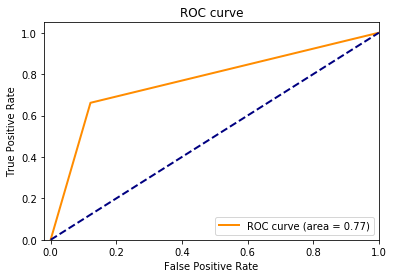

In [89]:
roc_graph(y_val, val_preds1)

## SVM

In [89]:
svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(C=16, class_weight={1:2, 0:1}, random_state=100))])
model_svc = svc_pipeline.fit(X_train, y_train)
y_hat_train_rbf = svc_pipeline.predict(X_train)
y_hat_val_rbf = svc_pipeline.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.95      0.91      0.93       922
        True       0.75      0.85      0.80       293

   micro avg       0.90      0.90      0.90      1215
   macro avg       0.85      0.88      0.87      1215
weighted avg       0.90      0.90      0.90      1215

Training Set Accuracy for SVM: 89.71%


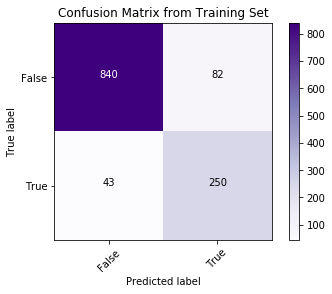

In [180]:
display_matrix(y_train, y_hat_train_rbf, data='Training Set', method='SVM')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.89      0.82      0.85       239
        True       0.48      0.62      0.54        65

   micro avg       0.77      0.77      0.77       304
   macro avg       0.68      0.72      0.69       304
weighted avg       0.80      0.77      0.78       304

Validation Set Accuracy for SVM: 77.3%


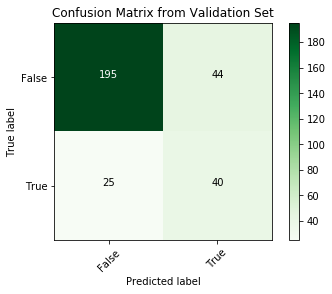

In [182]:
display_matrix(y_val, y_hat_val_rbf, data='Validation Set', method='SVM')

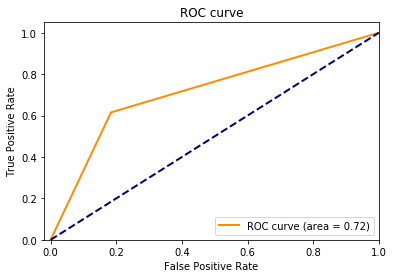

In [90]:
roc_graph(y_val, y_hat_val_rbf)

### SVM with GridSearchCV

In [91]:
parameters = {'svc__C':[0.1, 1, 10], 
              'svc__gamma':[0.01, 0.005],
              'svc__class_weight':[{0:1, 1:w} for w in [1, 2]]}

svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=100))])

In [92]:
grid_svm = GridSearchCV(svc_pipeline, param_grid=parameters, cv=5)
grid_svm.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(grid_svm.best_score_ * 100))
print("Optimal Parameters: {}".format(grid_svm.best_params_))

y_hat_train_rbf1 = grid_svm.predict(X_train)
y_hat_val_rbf1 = grid_svm.predict(X_val)

Testing Accuracy: 79.59%
Optimal Parameters: {'svc__C': 10, 'svc__class_weight': {0: 1, 1: 2}, 'svc__gamma': 0.005}


Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.88      0.87      0.87       922
        True       0.60      0.63      0.62       293

   micro avg       0.81      0.81      0.81      1215
   macro avg       0.74      0.75      0.75      1215
weighted avg       0.81      0.81      0.81      1215

Training Set Accuracy for SVM: 80.99%


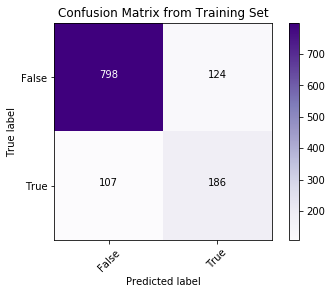

In [183]:
display_matrix(y_train, y_hat_train_rbf1, data='Training Set', method='SVM')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.89      0.89      0.89       239
        True       0.60      0.62      0.61        65

   micro avg       0.83      0.83      0.83       304
   macro avg       0.75      0.75      0.75       304
weighted avg       0.83      0.83      0.83       304

Validation Set Accuracy for SVM: 82.89%


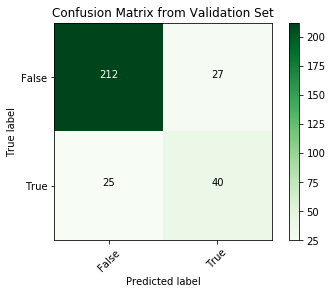

In [184]:
display_matrix(y_val, y_hat_val_rbf1, data='Validation Set', method='SVM')

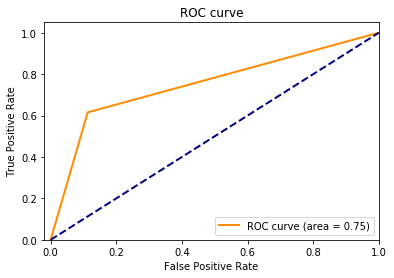

In [93]:
roc_graph(y_val, y_hat_val_rbf1)

## Optimizing The Best Model: XGBoost

In [184]:
param_grid = {
        'objective': ['binary:logistic'],
        'max_depth': [4, 5, 6, 7],
        'learning_rate': [0.10, 0.15, 0.20, 0.25],
        'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8],
        'colsample_bylevel': [0.2, 0.4, 0.6, 0.8],
        'min_child_weight': [15, 17, 19],
        'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
        'reg_lambda': [1.0, 5.0, 10.0, 20.0, 30.0],
        'n_estimators': [100]
        }

In [171]:
xgb_clf = xgb.XGBClassifier(scale_pos_weight=2.5)
rs_xgb_clf = RandomizedSearchCV(xgb_clf, param_grid, n_iter=1000,
            n_jobs=-1, cv=3, random_state=100)

rs_xgb_clf.fit(X_train, y_train)
best_score = rs_xgb_clf.best_score_
best_params = rs_xgb_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: 0.7917695473251029
Best params: 
colsample_bylevel: 0.6
colsample_bytree: 0.8
gamma: 0.4
learning_rate: 0.15
max_depth: 5
min_child_weight: 17
n_estimators: 100
objective: 'binary:logistic'
reg_lambda: 20.0
subsample: 0.8


Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.95      0.91      0.93       922
        True       0.76      0.85      0.80       293

   micro avg       0.90      0.90      0.90      1215
   macro avg       0.85      0.88      0.86      1215
weighted avg       0.90      0.90      0.90      1215

Training Set Accuracy for XGBoost: 89.71%


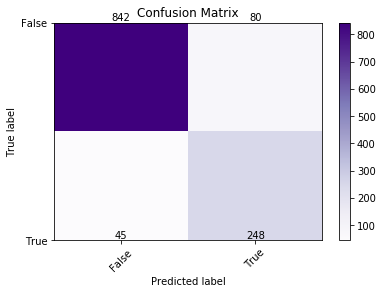

In [172]:
# rs_xgb_clf = rs_xgb_clf.best_estimator_
training_predictions = rs_xgb_clf.predict(X_train)
display_matrix(y_train, training_predictions, data='Training Set', method='XGBoost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.91      0.88      0.89       239
        True       0.60      0.66      0.63        65

   micro avg       0.83      0.83      0.83       304
   macro avg       0.75      0.77      0.76       304
weighted avg       0.84      0.83      0.84       304

Validation Set Accuracy for XGBoost: 83.22%


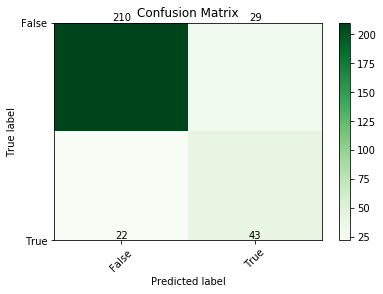

In [173]:
validation_predictions = rs_xgb_clf.predict(X_val)
display_matrix(y_val, validation_predictions, data='Validation Set', method='XGBoost')

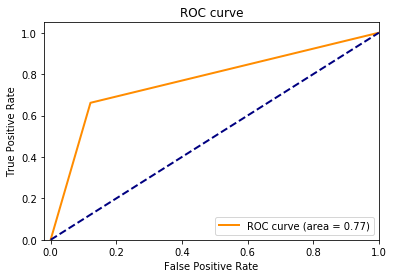

In [174]:
roc_graph(y_val, validation_predictions)

In [180]:
optimized_xgb = xgb_clf
optimized_xgb.fit(X_cv, y_cv)

training_prediction = optimized_xgb.predict(X_cv)
testing_prediction = optimized_xgb.predict(X_test)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.96      0.92      0.94      1161
        True       0.76      0.88      0.82       358

   micro avg       0.91      0.91      0.91      1519
   macro avg       0.86      0.90      0.88      1519
weighted avg       0.91      0.91      0.91      1519

Training Set Accuracy for XGBoost: 90.65%


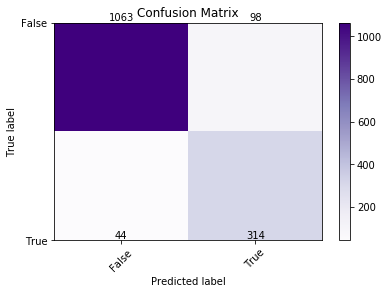

In [181]:
display_matrix(y_cv, training_prediction, data='Training Set', method='XGBoost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.90      0.87      0.89       291
        True       0.62      0.69      0.65        89

   micro avg       0.83      0.83      0.83       380
   macro avg       0.76      0.78      0.77       380
weighted avg       0.84      0.83      0.83       380

Validation Set Accuracy for XGBoost: 82.89%


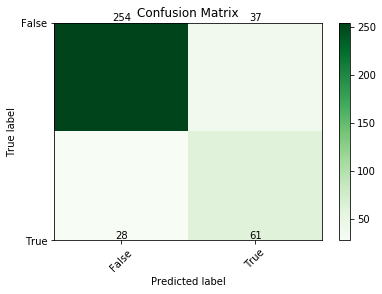

In [182]:
display_matrix(y_test, testing_prediction, data='Validation Set', method='XGBoost')

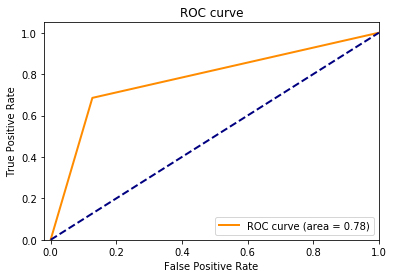

In [183]:
roc_graph(y_test, testing_prediction)

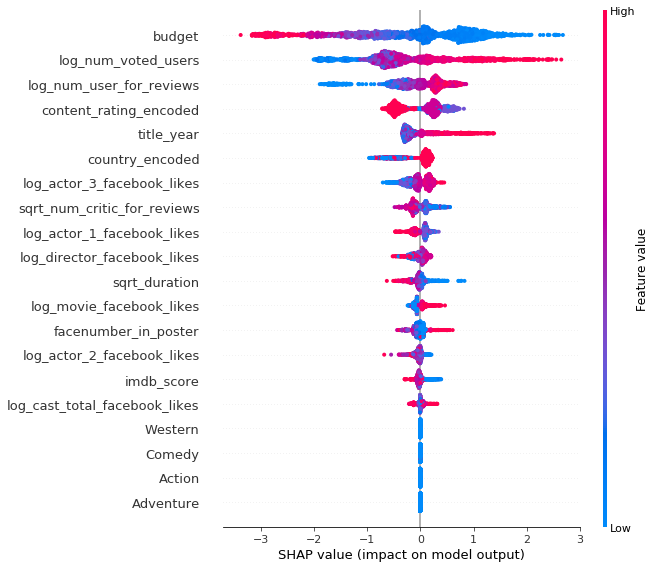

In [192]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(optimized_xgb)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X)

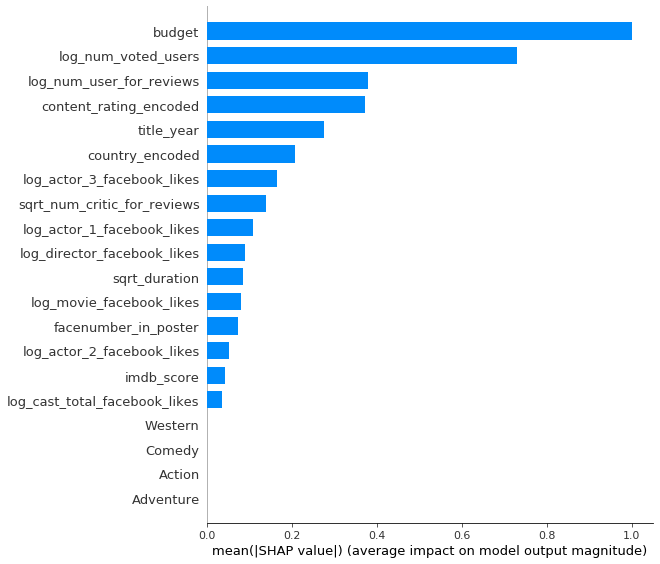

In [193]:
shap.summary_plot(shap_values, X, plot_type="bar")

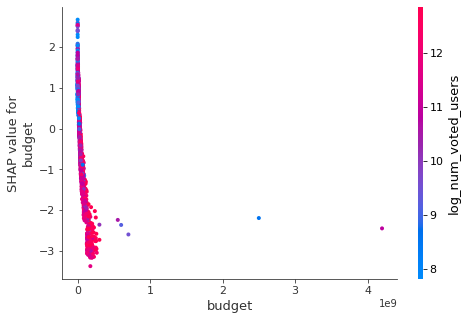

In [194]:
shap.dependence_plot("budget", shap_values, X)

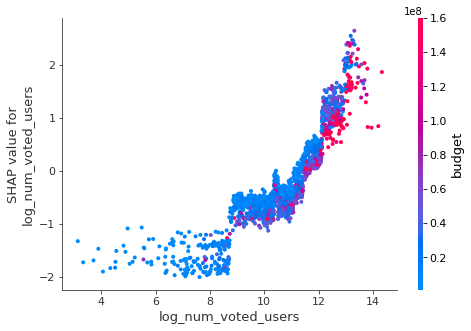

In [197]:
shap.dependence_plot("log_num_voted_users", shap_values, X)

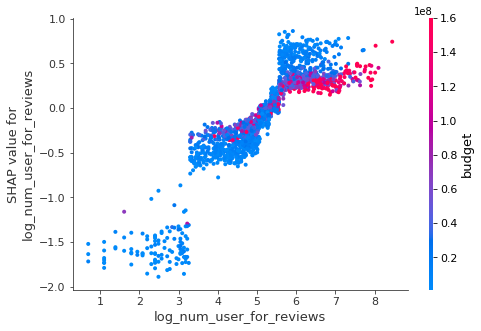

In [199]:
shap.dependence_plot("log_num_user_for_reviews", shap_values, X)